<h1 style="text-align: center">
Deep Learning HW4 </br>
VAE and CVAE
</h1>


### Full Name: Mohammad Javad Amin
### Student ID: 401211193

# Import necessary libraries

In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision

# Define the MNIST dataset and data loader

In [48]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Data Visualization

In [49]:
# Function to display an image
def show_image(image, figsize=(5, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

# Function to show random images from each class
def show_random_images_from_each_class(dataset, num_images_per_class=4, figsize=(10, 20)):
    class_labels = list(range(10))
    fig, axs = plt.subplots(len(class_labels), num_images_per_class, figsize=figsize)

    for i, label in enumerate(class_labels):
        class_indices = [idx for idx, target in enumerate(dataset.targets) if target == label]
        random_indices = random.sample(class_indices, num_images_per_class)

        for j, idx in enumerate(random_indices):

            image, target = dataset[idx]
            axs[i, j].imshow(image[0], cmap='gray')
            axs[i, j].set_title(f"Class {label}", fontsize=16)
            axs[i, j].axis('off')
            axs[i, j].set_aspect('equal')
            axs[i, j].grid(True)

    plt.tight_layout()
    plt.show()

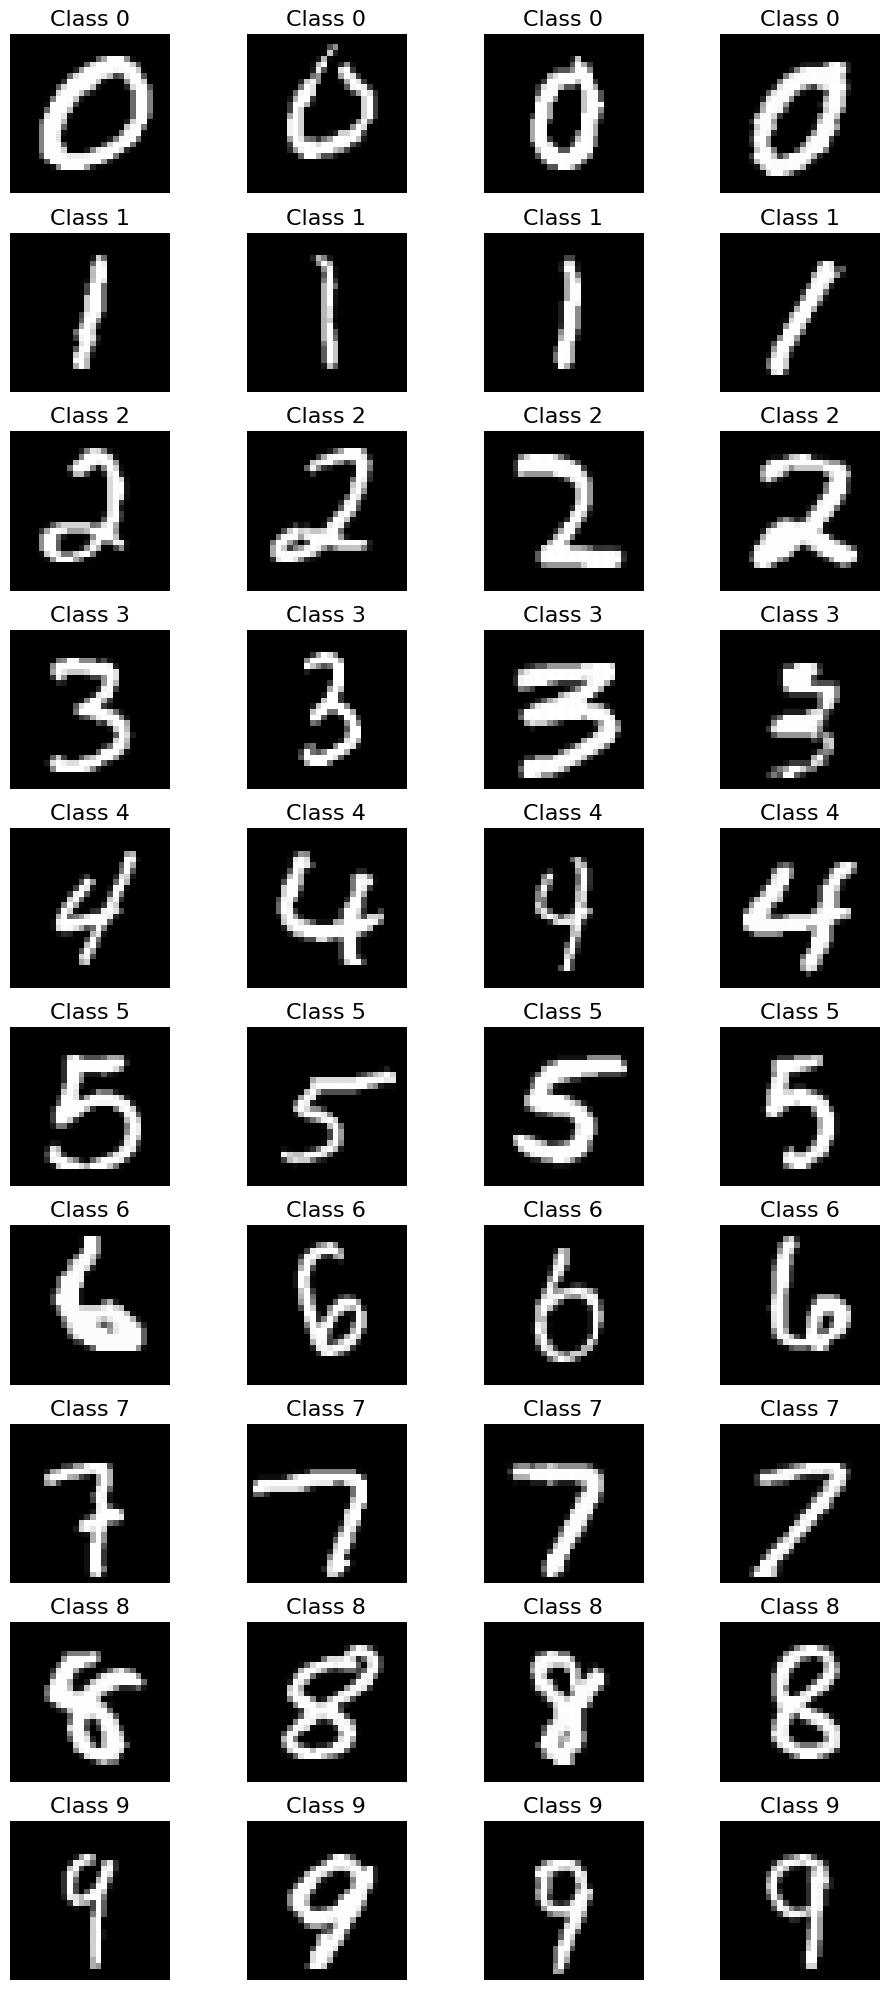

In [50]:
# Use the function to show random images from each class
show_random_images_from_each_class(train_dataset, num_images_per_class=4)

Exercise: Variational Autoencoders (VAE) and Conditional Variational Autoencoders (CVAE)

with MLP Architectures

In this exercise, we'll explore Variational Autoencoders (VAE) and Conditional VAE (CVAE) using PyTorch.

We will implement these models using Multi-Layer Perceptrons (MLP)

Let's get started!

# 1) VAE --> MLP

In [55]:
class VAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE_MLP, self).__init__()

        # Define the architecture of the encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Define the architecture of the decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid(),
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):

        x = x.view(x.size(0), -1)
      # Implement the forward pass
        # Encoder
        encoded = self.encoder(x)
        mu, logvar = self.fc_mu(encoded), self.fc_logvar(encoded)

        # Reparameterization trick
        z = self.reparameterize(mu, logvar)

        #Decoder
        reconstructed = self.decoder(z)

        return reconstructed, mu, logvar

In [59]:
def vae_loss(recon, data, mu, logvar):
    data = data.view(data.size(0), -1)
    # Implement the reconstruction loss
    reconstruction_loss = nn.functional.mse_loss(recon, data, reduction='sum')
    # print(reconstruction_loss)

    # Implement the KL divergence loss
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return reconstruction_loss + kl_divergence

In [60]:
def train_vae_mlp(model, train_loader, num_epochs=10, learning_rate=1e-3):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            # Forward process

            recon, mu, logvar = model(data)

            # Calculate the loss using the vae_loss function
            loss = vae_loss(recon, data, mu, logvar)

            # Backpropagation and optimization step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f'VAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        # Show some sample images after each epoch
        if (epoch + 1) % 1 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_samples = 6  # Generate num_samples random samples
                sample = torch.randn(num_samples, 2)

                sample = model.decoder(sample).view(num_samples, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_samples, figsize=(15, 2))
                for i in range(num_samples):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].axis('off')
                plt.show()

        # Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = model.state_dict()

    # Save the best model to a file
    torch.save(best_model, 'best_vae_mlp_model.pth')
    print("Best model saved as 'best_vae_mlp_model.pth'")


##################################################
VAE-MLP Epoch [1/10], Loss: 2897.933779458247
Sample Images:


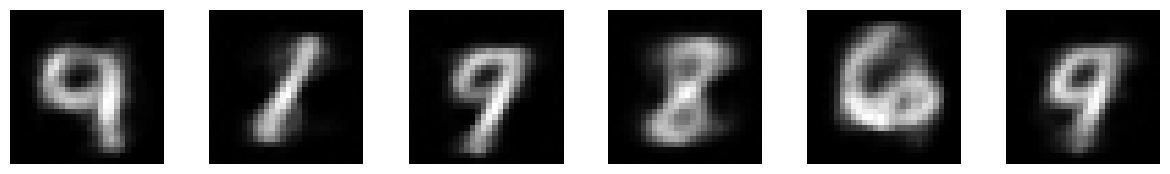


##################################################
VAE-MLP Epoch [2/10], Loss: 2539.484194106893
Sample Images:


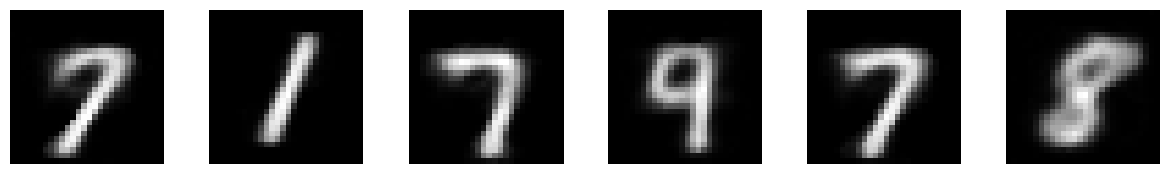


##################################################
VAE-MLP Epoch [3/10], Loss: 2433.244577371235
Sample Images:


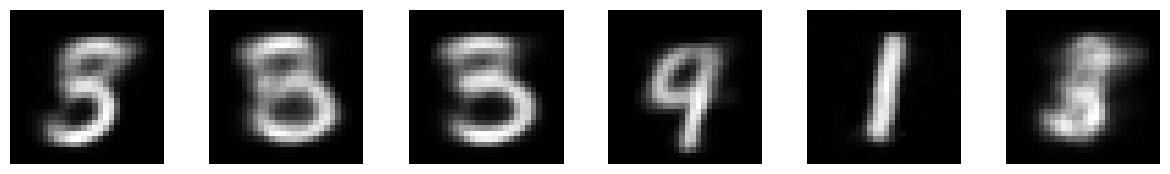


##################################################
VAE-MLP Epoch [4/10], Loss: 2375.212666265492
Sample Images:


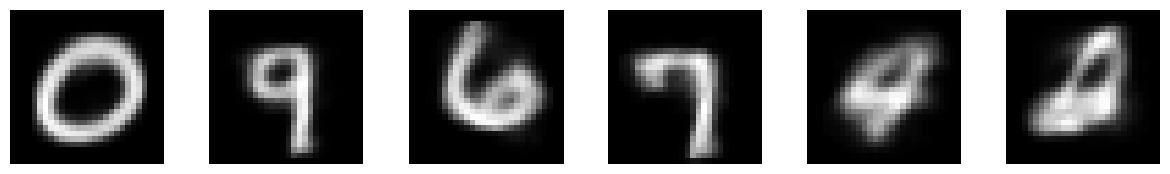


##################################################
VAE-MLP Epoch [5/10], Loss: 2331.829340107151
Sample Images:


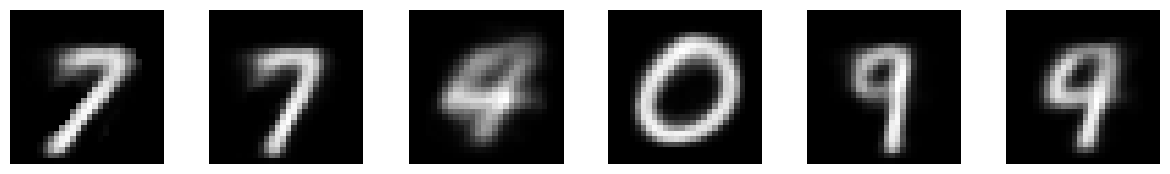


##################################################
VAE-MLP Epoch [6/10], Loss: 2306.709936341243
Sample Images:


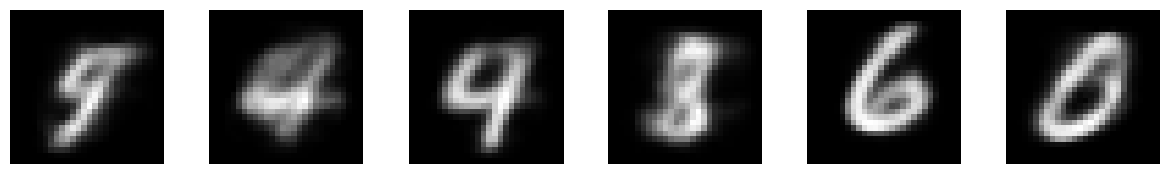


##################################################
VAE-MLP Epoch [7/10], Loss: 2284.2258480372966
Sample Images:


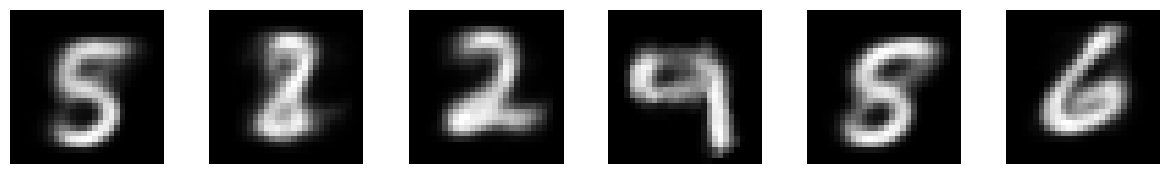


##################################################
VAE-MLP Epoch [8/10], Loss: 2267.4460726414663
Sample Images:


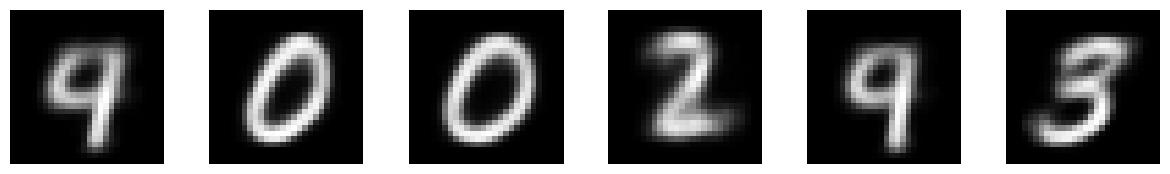


##################################################
VAE-MLP Epoch [9/10], Loss: 2254.1454722845733
Sample Images:


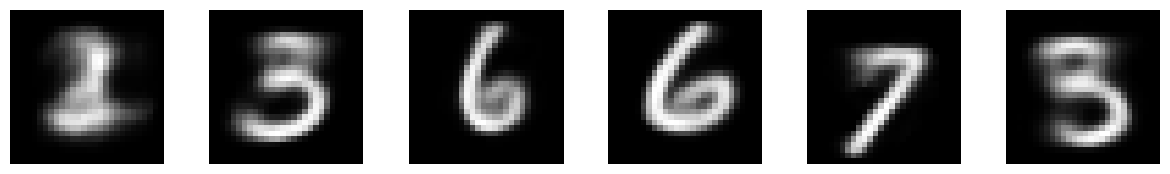


##################################################
VAE-MLP Epoch [10/10], Loss: 2243.0137625818315
Sample Images:


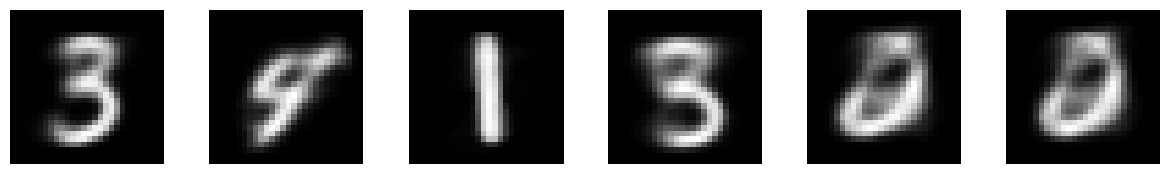

Best model saved as 'best_vae_mlp_model.pth'


In [61]:
# Train VAE-MLP
vae_mlp = VAE_MLP(input_dim=784, hidden_dim=400, latent_dim=2)
train_vae_mlp(vae_mlp, train_loader)

# 2) CVAE --> MLP

In [62]:
# Define a simple CVAE class with MLP architecture

class CVAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_classes):
        super(CVAE_MLP, self).__init__()
        #Define the architecture of the encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim+num_classes,hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim,hidden_dim),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc_class = nn.Linear(hidden_dim,num_classes)

        # Define the architecture of the decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim+num_classes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid(),
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x, y):
        x = x.view(x.size(0), -1)
        y = y.view(y.size(0), -1)

        # Concatenate x and y before passing them to the encoder
        x = torch.cat((x,y), dim=1)


        # Implement the forward pass
        # Encoder
        hidden = self.encoder(x)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)

        # Reparameterization trick
        z = self.reparameterize(mu, logvar)

        # Class prediction
        class_logits = self.fc_class(hidden)

        # Decoder
        z = torch.cat((z,y), dim=1)
        reconstructed = self.decoder(z)

        return reconstructed, mu, logvar, class_logits


In [63]:
# Define CVAE loss function
def cvae_loss(recon, data, mu, logvar, class_logits, labels):
    # Flatten the data tensor
    data = data.view(-1, recon.size(1))

    # Reconstruction loss
    reconstruction_loss = F.binary_cross_entropy(recon, data, reduction='sum')

    # KL divergence loss
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Cross-entropy loss for class prediction
    ce_loss = F.cross_entropy(class_logits, labels, reduction='sum')

    # Total loss as the sum of reconstruction, KL divergence, and cross-entropy losses
    total_loss = reconstruction_loss + kl_divergence + ce_loss

    return total_loss

In [64]:
# Training Loop - CVAE (MLP)
def train_cvae_mlp(model, train_loader, num_epochs=10, learning_rate=1e-3):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0
        for batch_idx, (data, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            # One-hot encode the labels
            labels_one_hot = F.one_hot(labels, num_classes=10).float()

            # Forward pass through the model and calculate the loss using cvae_loss
            recon, mu, logvar, class_logits = model(data, labels_one_hot)
            loss = cvae_loss(recon, data, mu, logvar, class_logits, labels)

            # Backpropagation and optimization step
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f'CVAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        # Show some sample images after each epoch
        if (epoch + 1) % 1 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_classes = 10  # Number of classes (0 to 9)
                num_samples_per_class = 1  # One sample per class
                # Generate random samples
                z = torch.randn(num_classes * num_samples_per_class, 2)
                # Generate one-hot encoded class labels
                y = torch.eye(num_classes).repeat(num_samples_per_class, 1)
                # Concatenate the random samples and class labels before passing them to the decoder
                sample = torch.cat([z, y], dim=1)
                sample = model.decoder(sample).view(num_classes * num_samples_per_class, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_classes, figsize=(15, 2))
                for i in range(num_classes):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].set_title(f"Class {i}", fontsize=16)
                    axs[i].axis('off')
                plt.show()

        # TODO: Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = model.state_dict()

    # Save the best model to a file
    torch.save(best_model, 'best_cvae_mlp_model.pth')
    print("Best model saved as 'best_cvae_mlp_model.pth'")



##################################################
CVAE-MLP Epoch [1/10], Loss: 10021.911769452125
Sample Images:


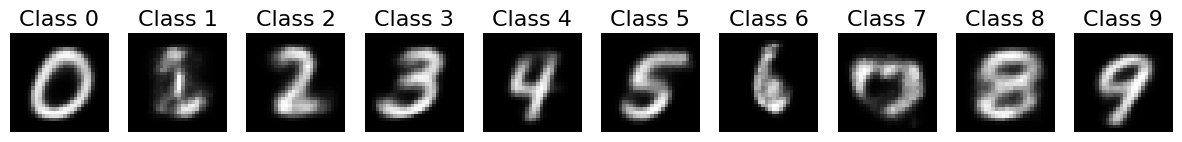


##################################################
CVAE-MLP Epoch [2/10], Loss: 8752.669694392158
Sample Images:


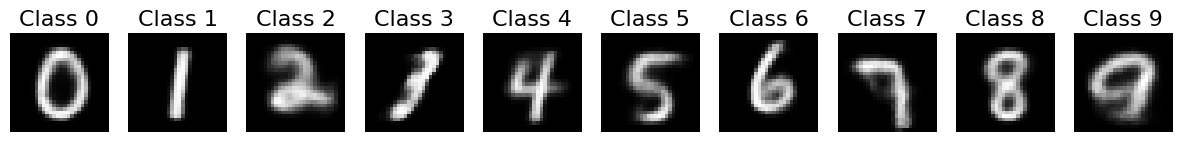


##################################################
CVAE-MLP Epoch [3/10], Loss: 8568.465570966318
Sample Images:


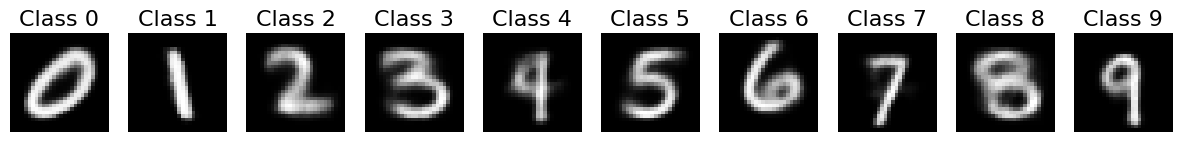


##################################################
CVAE-MLP Epoch [4/10], Loss: 8474.430891024787
Sample Images:


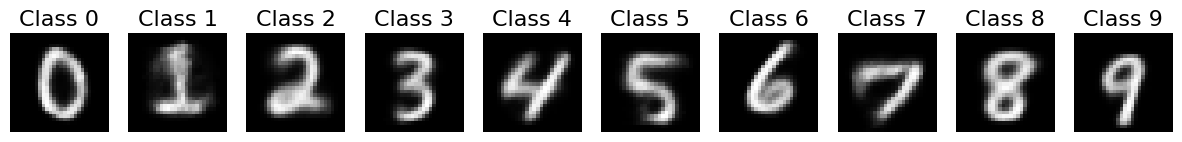


##################################################
CVAE-MLP Epoch [5/10], Loss: 8414.673809384994
Sample Images:


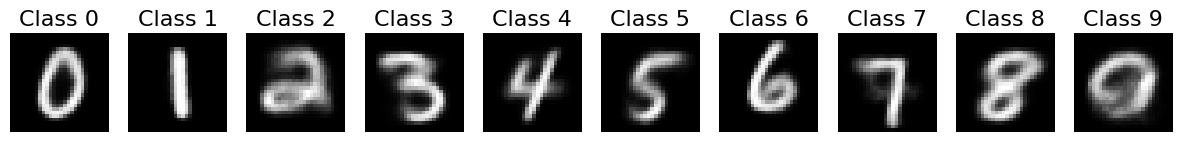


##################################################
CVAE-MLP Epoch [6/10], Loss: 8371.344820522805
Sample Images:


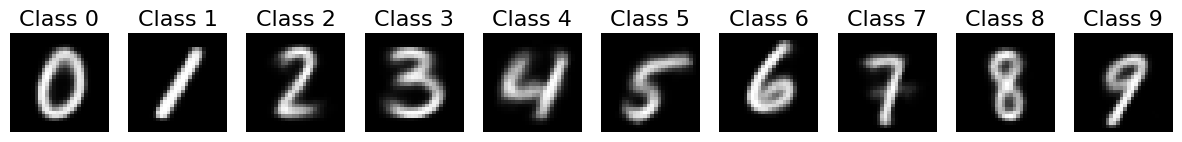


##################################################
CVAE-MLP Epoch [7/10], Loss: 8339.074245298341
Sample Images:


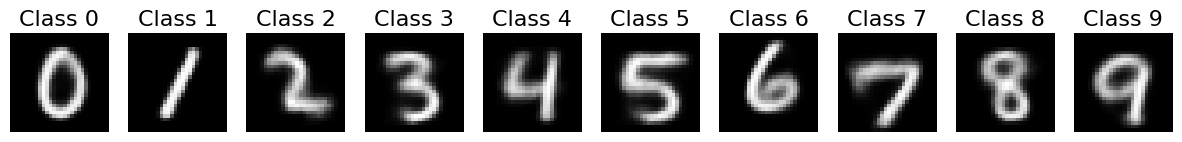


##################################################
CVAE-MLP Epoch [8/10], Loss: 8309.152992362408
Sample Images:


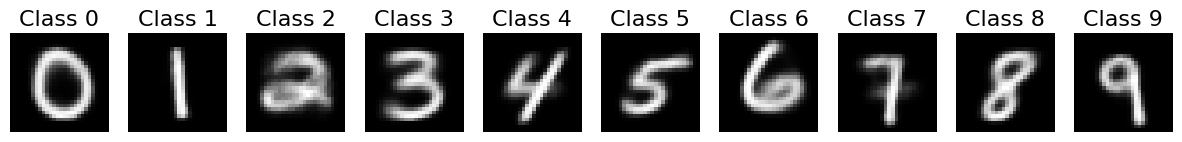


##################################################
CVAE-MLP Epoch [9/10], Loss: 8284.120744457123
Sample Images:


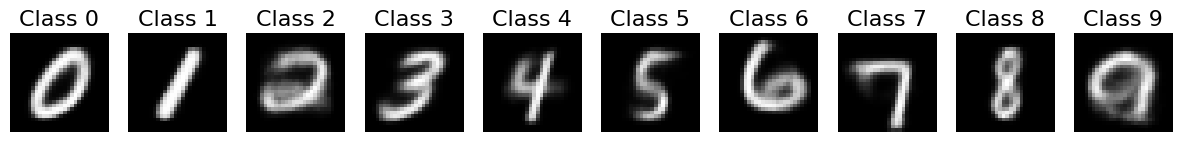


##################################################
CVAE-MLP Epoch [10/10], Loss: 8258.721705715285
Sample Images:


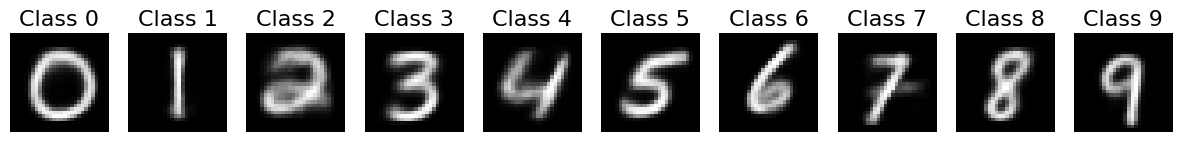

Best model saved as 'best_cvae_mlp_model.pth'


In [65]:
cvae_mlp = CVAE_MLP(input_dim=784, hidden_dim=400, latent_dim=2, num_classes=10)
train_cvae_mlp(cvae_mlp, train_loader)

# 3) Visualizing Latent Space Distribution in Two Models

In this section, we will visualize the latent space distribution for two different models:





In [92]:
def visualization(model,model_name,loader,num_samples=500):
  model.eval()
  labels=[]
  latent=[]

  for data, label in loader:

    if model_name=='CVAE':
      labels_one_hot = F.one_hot(label, num_classes=10).float()
      _, mu, _, _ = model(data, labels_one_hot)
    elif model_name =='VAE':
      _, mu, _ = model(data)
    else:
      print("Model Name is not valid \n")
      return
    latent.append(mu)
    labels.append(label)

  if num_samples > len(loader.dataset):
    num_samples = len(loader.dataset)
    print(f"Maximum number of sample is {len(loader.dataset)}")

  latent=torch.cat(latent,dim=0)[:num_samples].detach().numpy()
  labels = torch.cat(labels, dim=0)[:num_samples].detach().numpy()

  plt.figure(figsize=(12, 8))
  plt.scatter(latent[:, 0], latent[:, 1], c=labels, cmap='tab10')
  plt.title(f"Latent Space Distribution in Model {model_name}")
  plt.colorbar()
  plt.xlabel("Dimension 1")
  plt.ylabel("Dimension 2")
  plt.show()








## VAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in VAE model.
2. Analyze the characteristics of the distribution.


In [69]:
vae_mlp_best = VAE_MLP(input_dim=784, hidden_dim=400, latent_dim=2)
path_vae='best_vae_mlp_model.pth'
vae_mlp_best.load_state_dict(torch.load(path_vae))

<All keys matched successfully>

Maximum number of sample is 60000


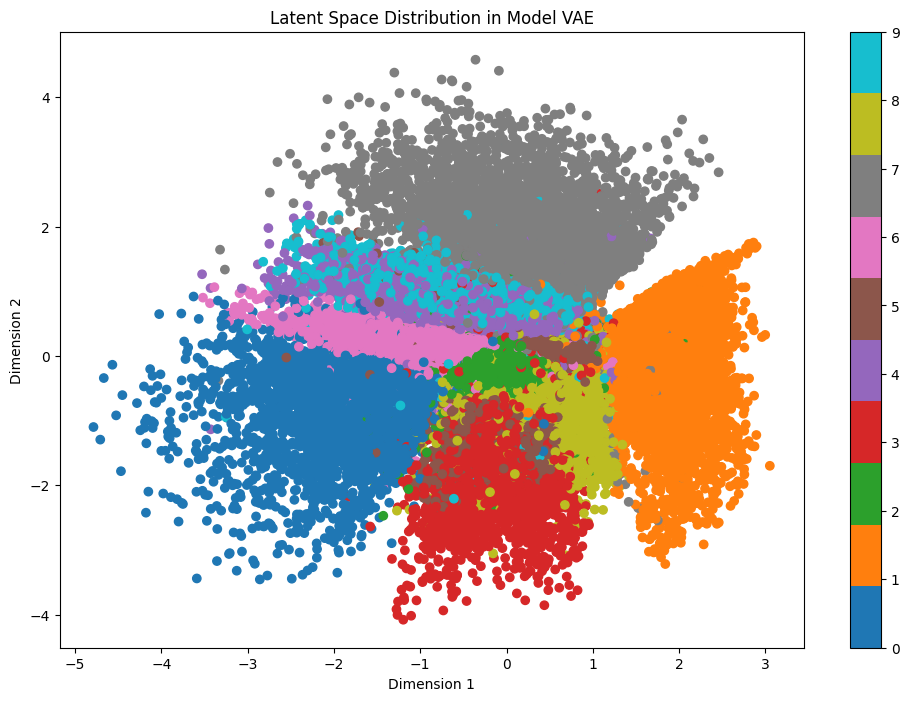

In [95]:
visualization(vae_mlp_best,'VAE',train_loader,num_samples=70000)


## CVAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in CVAE model.
2. Analyze the characteristics of the distribution.



In [85]:
cvae_mlp_best = CVAE_MLP(input_dim=784, hidden_dim=400, latent_dim=2, num_classes=10)
path_cvae='best_cvae_mlp_model.pth'
cvae_mlp_best.load_state_dict(torch.load(path_cvae))

<All keys matched successfully>

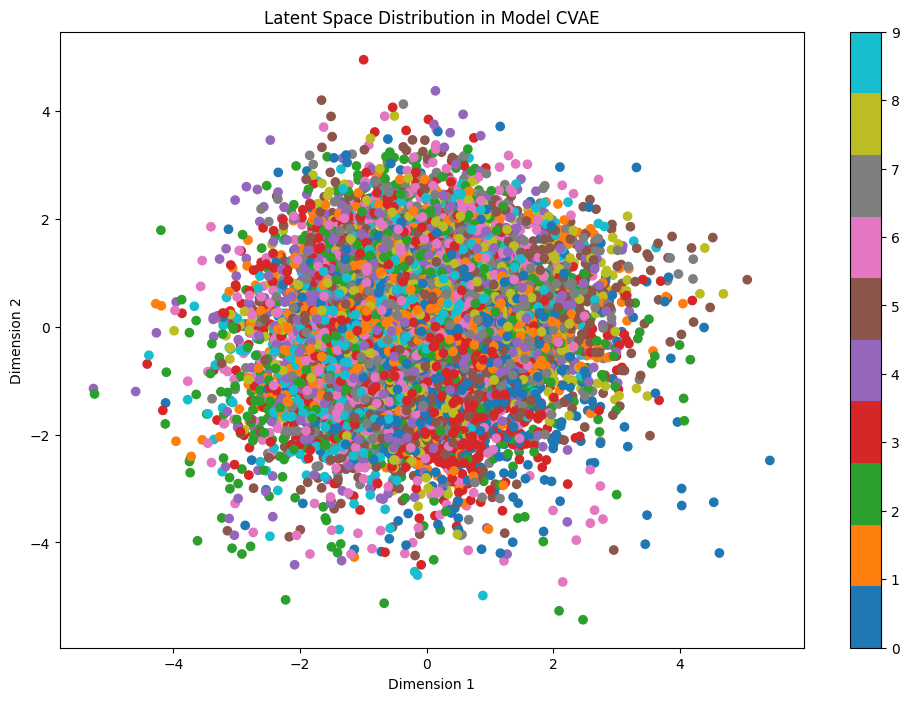

In [96]:
visualization(cvae_mlp_best,'CVAE',train_loader,num_samples=20000)
